# Extract CS2SMOS monthly SIT

In [1]:
import os
from glob import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import pyproj
from src.modules.grid.grid import Grid
from src.modules.topaz.v4.confmap import ConformalMapping

In [3]:
# load information for TOPAZ grid
cm = ConformalMapping.init_from_file('/users/edelleo1/tardis/tardis-ml/src/modules/grid.info')

In [4]:
# from src.modules.topaz.__init__()
# part of function >>read_grid()<<

nx = cm._ires
ny = cm._jres

ii, jj = np.meshgrid(np.arange(nx), np.arange(ny))
lat, lon = cm.gind2ll(ii+1., jj+1.)

# ##find grid resolution
geod = pyproj.Geod(ellps='sphere')
_,_,dist_x = geod.inv(lon[:,1:], lat[:,1:], lon[:,:-1], lat[:,:-1])
_,_,dist_y = geod.inv(lon[1:,:], lat[1:,:], lon[:-1,:], lat[:-1,:])
dx = np.median(dist_x)
dy = np.median(dist_y)

##the coordinates in topaz model native grid
x = ii*dx
y = jj*dy

##proj function that mimic what pyproj.Proj object does to convert x,y to lon,lat
def proj(x, y, inverse=False):
    if not inverse:
        i, j = cm.ll2gind(y, x)
        xo = (i-1)*dx
        yo = (j-1)*dy
    else:
        i = np.atleast_1d(x/dx + 1)
        j = np.atleast_1d(y/dy + 1)
        yo, xo = cm.gind2ll(i, j)
    if xo.size == 1:
        return xo.item(), yo.item()
    return xo, yo

# TOPAZ grid

#### Jiping used ANOTHER GRID for my version of TOPAZ

In [5]:
# my TOPAZ:

In [6]:
mtp_proj = pyproj.Proj('+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')

In [7]:
pyproj.Proj?

In [8]:
# get x, y

In [9]:
from src.data_preparation import load_data
import netCDF4 as nc4

In [10]:
ifile = '/scratch/project_465000269/edelleo1/Leo/Jiping_2023/TP4b/20221231_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

In [11]:
nc = nc4.Dataset(f'{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sithick']

In [12]:
xt, yt = np.meshgrid(sit.x.to_numpy(), sit.y.to_numpy())

In [13]:
t_grid = Grid(mtp_proj, xt*100000, yt*100000)

In [13]:
# t_grid = Grid(proj, x, y)

# CS2SMOS grid

All grids are projected onto the 25 km EASE2 Grid, which is based on a polar aspect spherical
Lambert azimuthal equal-area projection (Brodzik et al., 2012). The grid dimension is 5400 km
x 5400 km, equal to a 432 x 432 grid. The grid is centered on the geographic Pole, meaning
that the Pole is located at the intersection of center cells.
file:///home/leoede/Downloads/DT4-2_AWI_ESA_CS2SMOS_PDD_v1.5.pdf

In [14]:
in_proj = pyproj.Proj('+proj=laea +lon_0=0 +lat_0=90')

In [15]:
# x/y in data coordinates to lat/lon in meters
# in_proj(30,80, inverse=True)

# from lon/lat to x/y TOPAZ4b in meters
# proj(159.44395478041653, 89.99923505260686)  # 0,90)

In [16]:
# data_in = nc['analysis_sea_ice_thickness'][0].to_numpy()

# data_dx = nc['analysis_sea_ice_thickness'].xc.to_numpy()
# data_dy = nc['analysis_sea_ice_thickness'].yc.to_numpy()

# # create meshgrid for data (CS2SMOS)
# data_gx, data_gy = np.meshgrid(data_dx, data_dy)

# d_grid = Grid(in_proj, data_gx*1000, data_gy*1000)

# # define destination grid
# d_grid.dst_grid = t_grid

# # convert data
# data_out = d_grid.convert(data_in)

# Import CS2SMOS

In [17]:
# idir = '/nird/projects/nird/NS2993K/Leo/SIT_observations/CS2SMOS/v204/'

In [15]:
idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/CS2SMOS/cs2smos_205/'

In [16]:
listfile = sorted(glob(os.path.join(idir,'*.nc')))  # get all files

In [17]:
list_files = listfile[:1]

In [18]:
nc = xr.open_mfdataset(list_files, combine='nested', concat_dim='time')

In [19]:
nc['analysis_sea_ice_thickness']
# analysis_sea_ice_thickness_unc
# sea_ice_concentration

<xarray.DataArray 'analysis_sea_ice_thickness' (time: 1, yc: 432, xc: 432)>
dask.array<open_dataset-32a37c662da847530b7ab6d89261682danalysis_sea_ice_thickness, shape=(1, 432, 432), dtype=float64, chunksize=(1, 432, 432), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-11-04T12:00:00
  * xc       (xc) float32 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float32 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lon      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Attributes:
    units:          m
    long_name:      CS2SMOS merged sea ice thickness
    standard_name:  sea_ice_thickness
    grid_mapping:   Lambert_Azimuthal_Grid

In [20]:
cs2 = nc['analysis_sea_ice_thickness'].to_numpy()

In [21]:
sit_unc = nc['analysis_sea_ice_thickness_unc'].to_numpy()
sic = nc['sea_ice_concentration'].to_numpy()

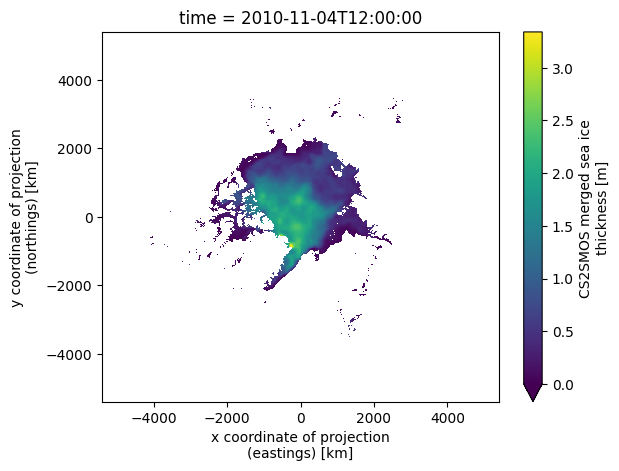

In [22]:
nc['analysis_sea_ice_thickness'][0].plot(vmin=0)

----------------

# Convert CS2SMOS with grid (Yue's module)

In [23]:
data_in = nc['analysis_sea_ice_thickness'][0].to_numpy()

In [24]:
data_dx = nc['analysis_sea_ice_thickness'].xc.to_numpy()
data_dy = nc['analysis_sea_ice_thickness'].yc.to_numpy()

In [25]:
data_dx

array([-5387.5, -5362.5, -5337.5, -5312.5, -5287.5, -5262.5, -5237.5,
       -5212.5, -5187.5, -5162.5, -5137.5, -5112.5, -5087.5, -5062.5,
       -5037.5, -5012.5, -4987.5, -4962.5, -4937.5, -4912.5, -4887.5,
       -4862.5, -4837.5, -4812.5, -4787.5, -4762.5, -4737.5, -4712.5,
       -4687.5, -4662.5, -4637.5, -4612.5, -4587.5, -4562.5, -4537.5,
       -4512.5, -4487.5, -4462.5, -4437.5, -4412.5, -4387.5, -4362.5,
       -4337.5, -4312.5, -4287.5, -4262.5, -4237.5, -4212.5, -4187.5,
       -4162.5, -4137.5, -4112.5, -4087.5, -4062.5, -4037.5, -4012.5,
       -3987.5, -3962.5, -3937.5, -3912.5, -3887.5, -3862.5, -3837.5,
       -3812.5, -3787.5, -3762.5, -3737.5, -3712.5, -3687.5, -3662.5,
       -3637.5, -3612.5, -3587.5, -3562.5, -3537.5, -3512.5, -3487.5,
       -3462.5, -3437.5, -3412.5, -3387.5, -3362.5, -3337.5, -3312.5,
       -3287.5, -3262.5, -3237.5, -3212.5, -3187.5, -3162.5, -3137.5,
       -3112.5, -3087.5, -3062.5, -3037.5, -3012.5, -2987.5, -2962.5,
       -2937.5, -291

In [26]:
# create meshgrid for data (CS2SMOS)
data_gx, data_gy = np.meshgrid(data_dx, data_dy)

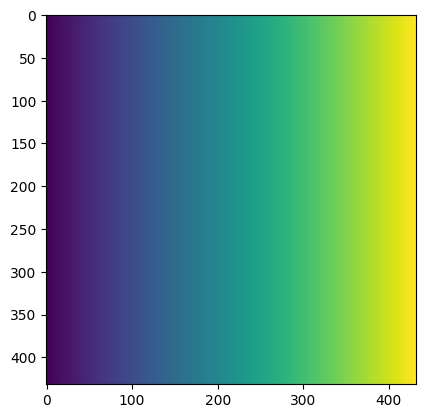

In [27]:
plt.imshow(data_gx)

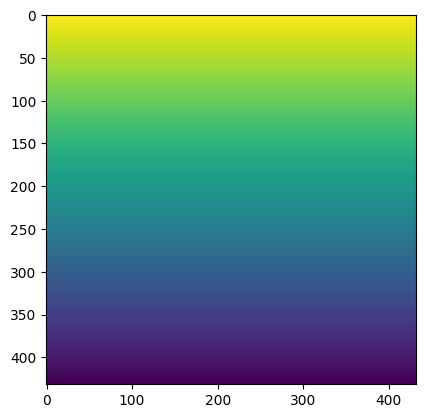

In [28]:
plt.imshow(data_gy)

In [29]:
d_grid = Grid(in_proj, data_gx*1000, data_gy*1000)

In [30]:
# define destination grid
d_grid.dst_grid = t_grid

In [31]:
# convert data
data_out = d_grid.convert(data_in)

## Plot input/output

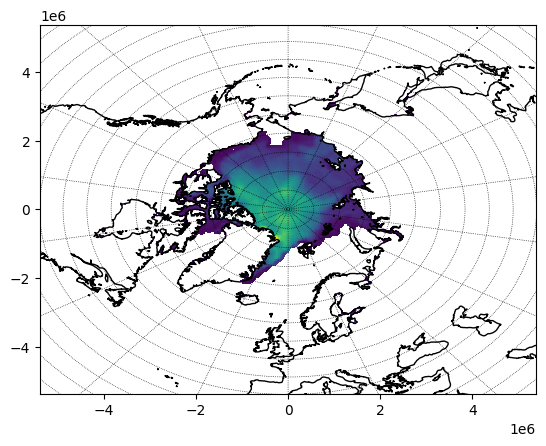

In [32]:
fig, ax = plt.subplots(1,1)
d_grid.plot_land(ax)
d_grid.plot_field(ax, data_in)

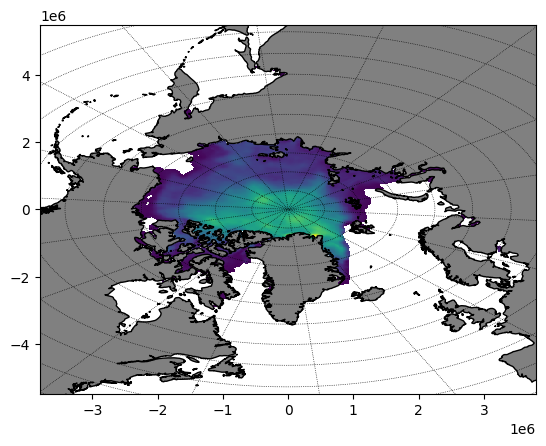

In [33]:
fig, ax = plt.subplots(1,1)
t_grid.plot_land(ax, color='grey')
t_grid.plot_field(ax, data_out)

In [62]:
t_grid.dx  # meters

12500.0

In [49]:
area = (t_grid.dx / t_grid.mfx) * (t_grid.dy / t_grid.mfx)

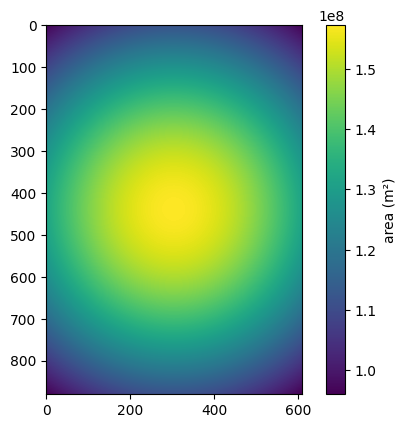

In [55]:
plt.imshow(area)
plt.colorbar(label='area (m²)')

In [67]:
np.nansum(data_out * area) / 1e9

7798.3589749211405

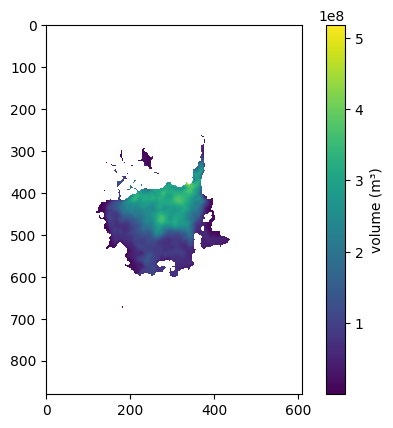

In [63]:
plt.imshow(data_out * area)
plt.colorbar(label='volume (m³)')

(881, 609)

In [34]:
data_out.shape

(881, 609)

In [35]:
# select the domain on TOPAZ we want
data_out2 = data_out[150:629, 100:550]

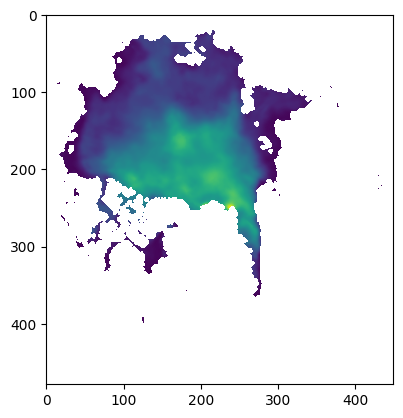

In [40]:
plt.imshow(data_out2[::-1,:])

# Convert each day 

In [154]:
def convert_alldays(grid, data_in, jlim=(100, 550), ilim=(150, 629)):
    '''
    Convert from CS2SMOS grid to TOPAZ grid (4b 2023 netcdf files, produced by Jiping)
    
    grid   : src.modules.grid.grid.grid.Grid
    new limits: [150:629, 100:550]
    '''
    
    
    
    nj = jlim[1] - jlim[0]  # number of j
    ni = ilim[1] - ilim[0] #  number of i
    nday = data_in.shape[0] # number of days
    data_out = np.zeros((nday, ni, nj))    
    
    for day in range(nday):
        data_out[day] = grid.convert(data_in[day])[ilim[0]:ilim[1], jlim[0]:jlim[1]]
        
    return data_out
    

In [155]:
cs2_out = convert_alldays(d_grid, cs2)

In [156]:
sit_unc2 = convert_alldays(d_grid, sit_unc)

In [157]:
sic2 = convert_alldays(d_grid, sic)

## Convert to xarray

In [158]:
xt = x[0,:]
yt = y[:,0]

In [160]:
xtc = xt[100:550]
ytc = yt[150:629]

In [161]:
da_sit = xr.DataArray(
    data=cs2_out.data,
    dims=["time", "y", "x"],
    coords=dict(
        x=(["x"], xtc),
        y=(["y"], ytc),
        time=(["time"], nc.time.data)
    ),
    attrs=dict(
        name="Sea ice thickness",
        description="CS2SMOS projected on TOPAZ4b grid",
        units="m",
    ),
)

da_sit.name = 'analysis_sea_ice_thickness'

In [ ]:
da_situ = xr.DataArray(
    data=sit_unc2.data,
    dims=["time", "y", "x"],
    coords=dict(
        x=(["x"], xtc),
        y=(["y"], ytc),
        time=(["time"], nc.time.data)
    ),
    attrs=dict(
        name="Sea ice thickness uncertainty",
        description="CS2SMOS projected on TOPAZ4b grid",
        units="m",
    ),
)

da_situ.name = 'analysis_sea_ice_thickness_unc'

In [162]:
da_sic = xr.DataArray(
    data=sic2.data,
    dims=["time", "y", "x"],
    coords=dict(
        x=(["x"], xtc),
        y=(["y"], ytc),
        time=(["time"], nc.time.data)
    ),
    attrs=dict(
        name="Sea ice concentration",
        description="CS2SMOS projected on TOPAZ4b grid",
        units="%",
    ),
)

da_sic.name = 'sea_ice_concentration'

# Xarray Dataset

In [164]:
ds = xr.merge((da_sit, da_situ, da_sic))

In [165]:
ds.attrs['name'] = 'CS2SMOS'

## Save .nc

In [166]:
start_date = os.path.basename(list_files[0]).split('_')[5]
end_date = os.path.basename(list_files[-1]).split('_')[6]
str_date = f'{start_date}_{end_date}'

In [168]:
# odir = '/nird/projects/nird/NS2993K/Leo/SIT_observations/CS2SMOS/results/'
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/CS2SMOS/results/'
ofile = f'CS2SMOS_v205_{str_date}.nc'

ds.to_netcdf(f'{odir}{ofile}')
print(f'Saved as: {odir}{ofile}')

# ----------------

# ---------------- old script -------------------

# ----------------

-----

## PLOT

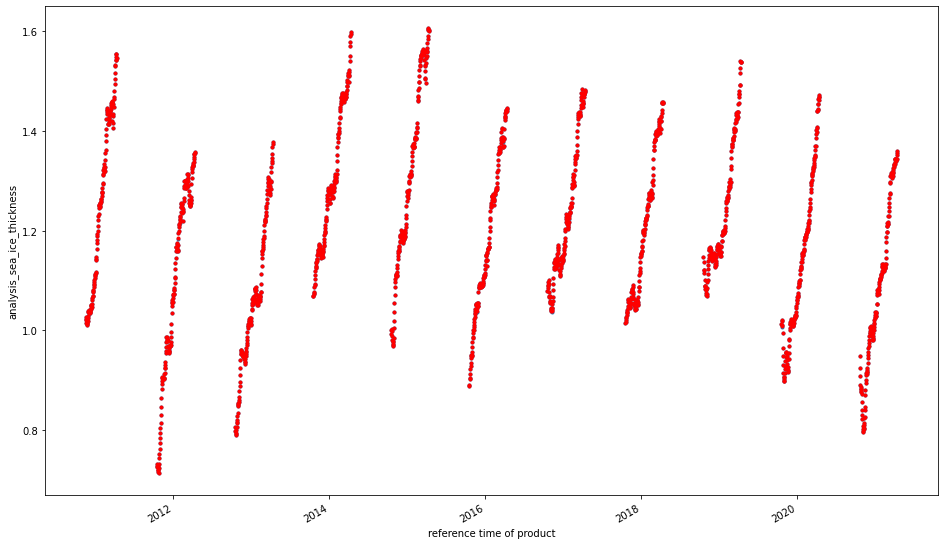

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
sim.plot(marker='.', ls='')
sim_c15.plot(c='r', marker='.', ls='')

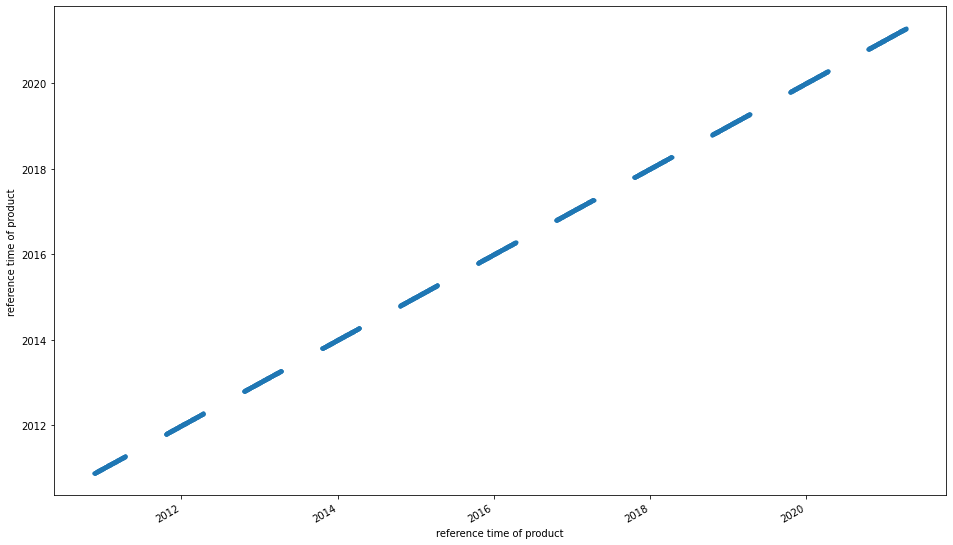

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
sim.time.plot(marker='.', ls='')

-----

### Draft